# Кредиты

Данные из Бюро кредитных историй. \
То есть для каждой заявки на кредит есть N набор данных его прошлых кредитов.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import seaborn as sns
import plotly.express as px
import tqdm

from pathlib import Path
from glob import glob
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Данные

In [3]:
df_target = pd.read_csv("/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_target.csv")

In [4]:
df_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


In [5]:
# объединим все файлы с данными в один
data_dir = Path("/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные")

In [6]:
df = pd.concat([pd.read_parquet(f, engine='fastparquet') for f in data_dir.glob("*.pq")], ignore_index=True)

In [12]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,2250000,1,4,2,9,12,5,7,6,2,...,3,3,3,4,1,3,5,1,0,0
1,2250000,2,3,17,15,9,15,14,1,2,...,3,3,3,4,1,3,4,1,0,0
2,2250000,3,3,3,16,9,15,14,10,2,...,3,3,3,4,1,3,4,1,0,0
3,2250000,4,11,17,14,7,14,8,9,2,...,3,3,3,4,1,3,4,1,0,0
4,2250000,5,11,6,4,8,1,11,14,2,...,3,3,3,4,1,2,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26162712,1249999,11,7,2,11,8,10,11,11,2,...,3,3,3,4,1,2,4,1,0,1
26162713,1249999,12,7,5,14,11,10,15,11,2,...,3,3,3,4,1,3,4,1,0,0
26162714,1249999,13,7,9,4,8,1,11,16,3,...,3,3,3,4,1,2,3,1,1,1
26162715,1249999,14,19,9,4,8,1,11,8,2,...,3,3,3,4,1,2,3,1,1,1


# Исследование данных

In [13]:
df.shape

(26162717, 61)

В датасете 26 млн строк и 61 столбец

In [14]:
df.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

У каждой заявки 60 категориальных признаков:

0. id – идентификатор заявки
1. rn – порядковый номер кредитного продукта в кредитной истории
2. pre_since_opened – дней с даты открытия кредита до даты сбора данных
3. pre_since_confirmed – дней с даты подтверждения информации по кредиту до даты сбора данных
4. pre_pterm – плановое количество дней с даты открытия кредита до даты закрытия
5. pre_fterm – фактическое количество дней с даты открытия кредита до даты закрытия
6. pre_till_pclose – плановое количество дней с даты сбора данных до даты закрытия кредита
7. pre_till_fclose – фактическое количество дней с даты сбора данных до даты закрытия кредита
8. pre_loans_credit_limit – кредитный лимит
9. pre_loans_next_pay_summ – сумма следующего платежа по кредиту
10. pre_loans_outstanding – оставшаяся невыплаченная сумма кредита
11. pre_loans_total_overdue – текущая просроченная задолженность
12. pre_loans_max_overdue_sum – максимальная просроченная задолженность
13. pre_loans_credit_cost_rate – полная стоимость кредита
14. pre_loans5 – число просрочек до 5 дней
15. pre_loans530 – число просрочек от 5 до 30 дней
16. pre_loans3060 – число просрочек от 30 до 60 дней
17. pre_loans6090 – число просрочек от 60 до 90 дней
18. pre_loans90 – число просрочек более, чем на 90 дней
19. is_zero_loans_5 – флаг: нет просрочек до 5 дней
20. is_zero_loans_530 – флаг: нет просрочек от 5 до 30 дней
21. is_zero_loans_3060 – флаг: нет просрочек от 30 до 60 дней
22. is_zero_loans_6090 – флаг: нет просрочек от 60 до 90 дней
23. is_zero_loans90 – флаг: нет просрочек более, чем на 90 дней
24. pre_util – отношение оставшейся невыплаченной суммы кредита к кредитному лимиту
25. pre_over2limit – отношение текущей просроченной задолженности к кредитному лимиту
26. pre_maxover2limit – отношение максимальной просроченной задолженности к кредитному лимиту
27. is_zero_util – флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равняется 0
28. is_zero_over2limit – флаг: отношение текущей просроченной задолженности к кредитному лимиту равняется 0
29. is_zero_maxover2limit – флаг: отношенение максимальной просроченной задолженности к кредитному лимиту равняется 0
30. enc_paym_{0..n} – статусы ежемесячных платежей за последние n месяцев
31. enc_loans_account_holder_type – тип отношения к кредиту
32. enc_loans_credit_status – статус кредита
33. enc_loans_account_cur – валюта кредита
34. enc_loans_credit_type – тип кредита
35. pclose_flag – флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено
36. fclose_flag – флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено

## 1. Кол-во уникальных значений и null

In [15]:
count_null = []

for i in df.columns:
    count_null.append(df[i].isna().sum())

In [16]:
df_count_null = pd.DataFrame()

df_count_null['Name'] = df.columns
df_count_null['Count_null'] = count_null
df_count_null['Share_null'] = [(i/df.shape[0])*100 for i in count_null]

In [17]:
df_count_null.sort_values(by=['Share_null']).reset_index(drop=True)

,Name,Count_null,Share_null
0,id,0,0.0
1,enc_paym_2,0,0.0
2,enc_paym_3,0,0.0
3,enc_paym_4,0,0.0
4,enc_paym_5,0,0.0
...,...,...,...
56,pre_over2limit,0,0.0
57,pre_maxover2limit,0,0.0
58,is_zero_util,0,0.0
59,is_zero_maxover2limit,0,0.0


В датасете нет пустых значений

In [18]:
col = []
count_unique = []

for i in df.columns:
    col.append(i)
    count_unique.append(df[i].nunique())

In [19]:
d = dict(zip(col, count_unique))
d

{'id': 3000000,
 'rn': 58,
 'pre_since_opened': 20,
 'pre_since_confirmed': 18,
 'pre_pterm': 18,
 'pre_fterm': 17,
 'pre_till_pclose': 17,
 'pre_till_fclose': 16,
 'pre_loans_credit_limit': 20,
 'pre_loans_next_pay_summ': 7,
 'pre_loans_outstanding': 5,
 'pre_loans_total_overdue': 2,
 'pre_loans_max_overdue_sum': 4,
 'pre_loans_credit_cost_rate': 14,
 'pre_loans5': 13,
 'pre_loans530': 20,
 'pre_loans3060': 10,
 'pre_loans6090': 5,
 'pre_loans90': 7,
 'is_zero_loans5': 2,
 'is_zero_loans530': 2,
 'is_zero_loans3060': 2,
 'is_zero_loans6090': 2,
 'is_zero_loans90': 2,
 'pre_util': 20,
 'pre_over2limit': 20,
 'pre_maxover2limit': 20,
 'is_zero_util': 2,
 'is_zero_over2limit': 2,
 'is_zero_maxover2limit': 2,
 'enc_paym_0': 4,
 'enc_paym_1': 4,
 'enc_paym_2': 4,
 'enc_paym_3': 4,
 'enc_paym_4': 4,
 'enc_paym_5': 4,
 'enc_paym_6': 4,
 'enc_paym_7': 4,
 'enc_paym_8': 4,
 'enc_paym_9': 4,
 'enc_paym_10': 4,
 'enc_paym_11': 4,
 'enc_paym_12': 4,
 'enc_paym_13': 4,
 'enc_paym_14': 4,
 'enc_pay

В датассете 3 млн уникальных заявок на кредит, у каждой заявки есть определнный набор ответов из БКИ.

## 2. Частотный анализ

Проведем анализ категориальных переменных.

Почти все переменные в датасете либо бинаризованы, либо закондированы. 

Поэтому анализ проводился по переменным, которые имеют незакодированные значения: rn, is_zero_loans5, is_zero_loans530, is_zero_loans3060, is_zero_loans6090, is_zero_loans90, is_zero_util, is_zero_over2limit, is_zero_maxover2limit, pclose_flag, fclose_flag.

**rn**

Text(0.5, 0, 'rn')

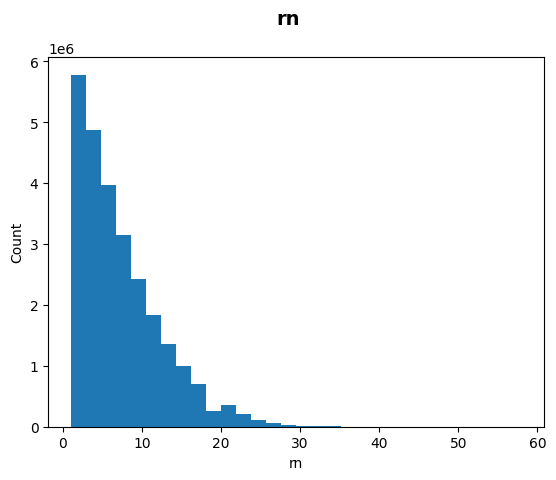

In [39]:
plt.hist(df['rn'], bins=30)  # density=False would make counts
plt.suptitle('rn', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('rn')

In [16]:
df.groupby('rn').agg({'id': 'count'}).sort_values(['id'], ascending = False)

,id
rn,
1,3000000
2,2779455
3,2550810
4,2320731
5,2094188
6,1876509
7,1668536
8,1473997
9,1294408


Около 50% клиентов брали больше 8 кредитов перед подачей заявки, а больше 20 кредитов брали только 7% клиентов.

Следующие переменные связаны непосредственно с самим кредитом, а не с зявкой, поэтому для анализа потребуется некоторая предобработка

**is_zero_loans5**

In [26]:
df_loans5 = pd.DataFrame()

df_loans5['Sum_loans5'] = df.groupby('id').agg({'is_zero_loans5': 'sum'})
df_loans5['Count_cred'] = df.groupby('id').agg({'is_zero_loans5': 'count'})

In [27]:
df_loans5['not_loans'] = round(df_loans5['Sum_loans5']/df_loans5['Count_cred'], 2)

In [28]:
df_loans5

,Sum_loans5,Count_cred,not_loans
id,,,
0,9,10,0.90
1,12,14,0.86
2,3,3,1.00
3,15,15,1.00
4,1,1,1.00
...,...,...,...
2999995,9,11,0.82
2999996,12,13,0.92
2999997,9,10,0.90


Text(0.5, 0, 'not_loans')

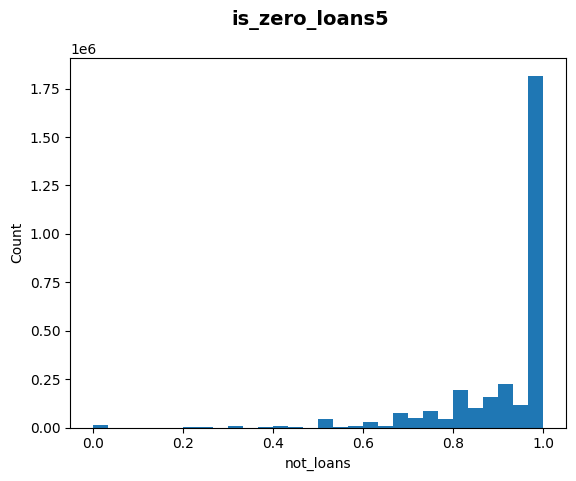

In [36]:
plt.hist(df_loans5['not_loans'], density=False, bins=30)  # density=False would make counts
plt.suptitle('is_zero_loans5', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_loans')

Видим, что примерно 60% клиентов не имели или не имеют просрочку больше 5 дней.

**is_zero_loans530**

In [31]:
df_loans530 = pd.DataFrame()

df_loans530['Sum_loans530'] = df.groupby('id').agg({'is_zero_loans530': 'sum'})
df_loans530['Count_cred'] = df.groupby('id').agg({'is_zero_loans530': 'count'})

In [32]:
df_loans530['not_loans'] = round(df_loans530['Sum_loans530']/df_loans530['Count_cred'], 2)

In [33]:
df_loans530

,Sum_loans530,Count_cred,not_loans
id,,,
0,10,10,1.00
1,10,14,0.71
2,2,3,0.67
3,15,15,1.00
4,1,1,1.00
...,...,...,...
2999995,5,11,0.45
2999996,13,13,1.00
2999997,7,10,0.70


Text(0.5, 0, 'not_loans')

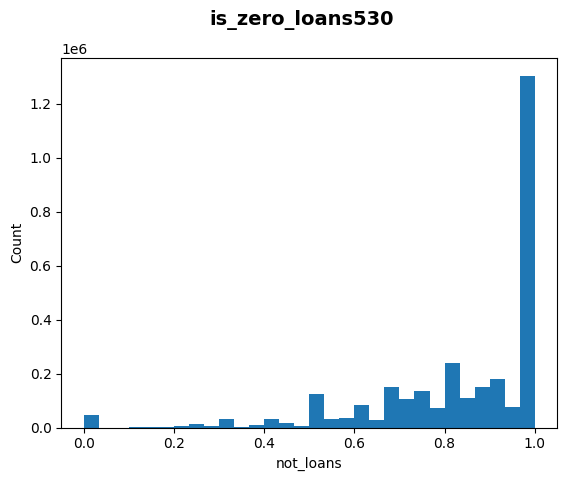

In [35]:
plt.hist(df_loans530['not_loans'], density=False, bins=30)  # density=False would make counts
plt.suptitle('is_zero_loans530', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_loans')

Около 44% клиентов не имели/не имеют просрочку от 5 до 30 дней.

**is_zero_loans3060**

In [40]:
df_loans3060 = pd.DataFrame()

df_loans3060['Sum_loans3060'] = df.groupby('id').agg({'is_zero_loans3060': 'sum'})
df_loans3060['Count_cred'] = df.groupby('id').agg({'is_zero_loans3060': 'count'})

In [41]:
df_loans3060['not_loans'] = round(df_loans3060['Sum_loans3060']/df_loans3060['Count_cred'], 2)

In [42]:
df_loans3060

,Sum_loans3060,Count_cred,not_loans
id,,,
0,10,10,1.00
1,12,14,0.86
2,2,3,0.67
3,15,15,1.00
4,1,1,1.00
...,...,...,...
2999995,11,11,1.00
2999996,12,13,0.92
2999997,10,10,1.00


Text(0.5, 0, 'not_loans')

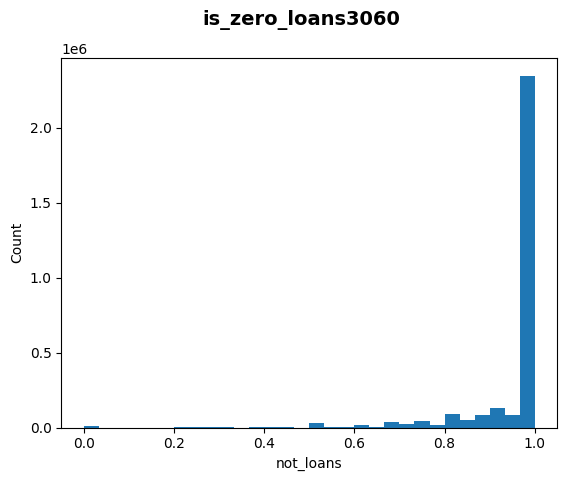

In [43]:
plt.hist(df_loans3060['not_loans'], density=False, bins=30) 
plt.suptitle('is_zero_loans3060', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_loans')

77% клиентов не имеют/не имели просрочку от 30 до 60 дней

**is_zero_loans6090**

In [44]:
df_loans6090 = pd.DataFrame()

df_loans6090['Sum_loans6090'] = df.groupby('id').agg({'is_zero_loans6090': 'sum'})
df_loans6090['Count_cred'] = df.groupby('id').agg({'is_zero_loans6090': 'count'})

In [45]:
df_loans6090['not_loans'] = round(df_loans6090['Sum_loans6090']/df_loans6090['Count_cred'], 2)

In [46]:
df_loans6090

,Sum_loans6090,Count_cred,not_loans
id,,,
0,10,10,1.00
1,12,14,0.86
2,2,3,0.67
3,15,15,1.00
4,1,1,1.00
...,...,...,...
2999995,11,11,1.00
2999996,13,13,1.00
2999997,10,10,1.00


Text(0.5, 0, 'not_loans')

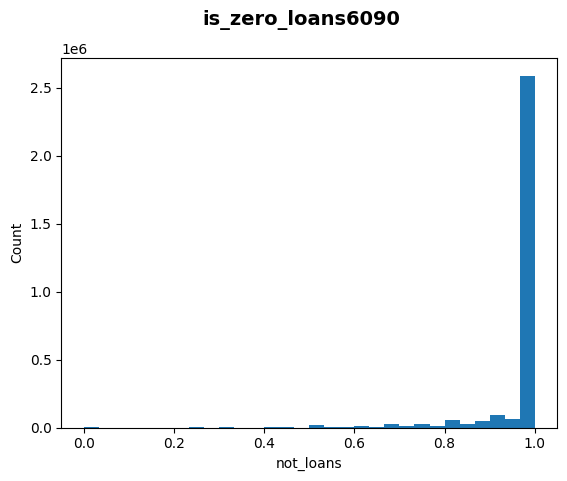

In [47]:
plt.hist(df_loans6090['not_loans'], density=False, bins=30) 
plt.suptitle('is_zero_loans6090', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_loans')

Примерно 86% клиентов не имеют просрочку от 60 до 90 дней

**is_zero_loans90**

In [48]:
df_loans90 = pd.DataFrame()

df_loans90['Sum_loans90'] = df.groupby('id').agg({'is_zero_loans90': 'sum'})
df_loans90['Count_cred'] = df.groupby('id').agg({'is_zero_loans90': 'count'})

In [49]:
df_loans90['not_loans'] = round(df_loans90['Sum_loans90']/df_loans90['Count_cred'], 2)

In [50]:
df_loans90

,Sum_loans90,Count_cred,not_loans
id,,,
0,10,10,1.00
1,11,14,0.79
2,3,3,1.00
3,15,15,1.00
4,1,1,1.00
...,...,...,...
2999995,11,11,1.00
2999996,13,13,1.00
2999997,10,10,1.00


Text(0.5, 0, 'not_loans')

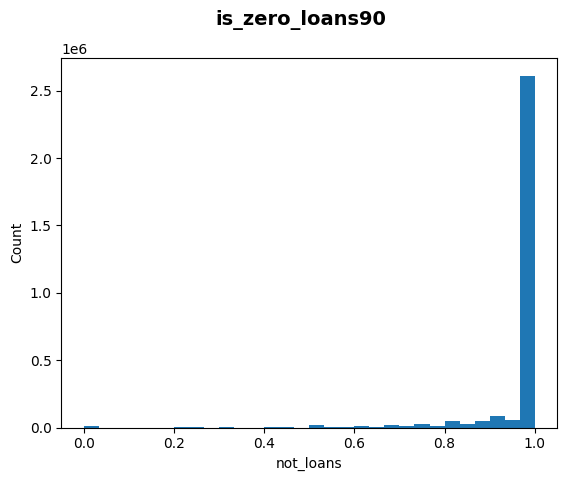

In [55]:
plt.hist(df_loans90['not_loans'], density=False, bins=30) 
plt.suptitle('is_zero_loans90', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_loans')

Примерно 87% клиентов не имеют/не имели просрочку более 90 дней

**is_zero_util**

In [56]:
df_util = pd.DataFrame()

df_util['Sum_util'] = df.groupby('id').agg({'is_zero_util': 'sum'})
df_util['Count_cred'] = df.groupby('id').agg({'is_zero_util': 'count'})

In [57]:
df_util['not_util'] = round(df_util['Sum_util']/df_util['Count_cred'], 2)

In [58]:
df_util

,Sum_util,Count_cred,not_util
id,,,
0,6,10,0.60
1,10,14,0.71
2,1,3,0.33
3,8,15,0.53
4,1,1,1.00
...,...,...,...
2999995,8,11,0.73
2999996,9,13,0.69
2999997,6,10,0.60


Text(0.5, 0, 'not_util')

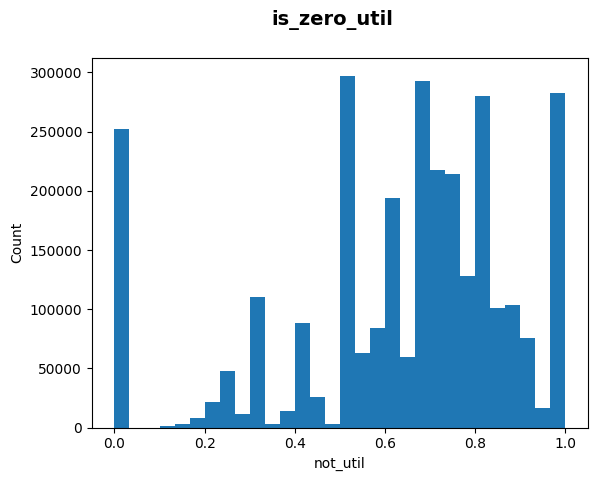

In [61]:
plt.hist(df_util['not_util'], density=False, bins=30) 
plt.suptitle('is_zero_util', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_util')

У 8ми процентов клиентов отношение остатка задолженностии к кредитному лимиту не 0, то есть кредит не выплачен. У 10ти процентов половина кредитов выплачена, у 9ти процентов все кредиты выплачены. \
У основной части клиентов болнее 50% кредитов выплачены.

**is_zero_over2limit**

In [7]:
df_over2limit = pd.DataFrame()

df_over2limit['Sum_over2limit'] = df.groupby('id').agg({'is_zero_over2limit': 'sum'})
df_over2limit['Count_cred'] = df.groupby('id').agg({'is_zero_over2limit': 'count'})

In [8]:
df_over2limit['not_over2limit'] = round(df_over2limit['Sum_over2limit']/df_over2limit['Count_cred'], 2)

In [9]:
df_over2limit

,Sum_over2limit,Count_cred,not_over2limit
id,,,
0,9,10,0.90
1,12,14,0.86
2,3,3,1.00
3,14,15,0.93
4,1,1,1.00
...,...,...,...
2999995,11,11,1.00
2999996,11,13,0.85
2999997,10,10,1.00


Text(0.5, 0, 'not_over2limit')

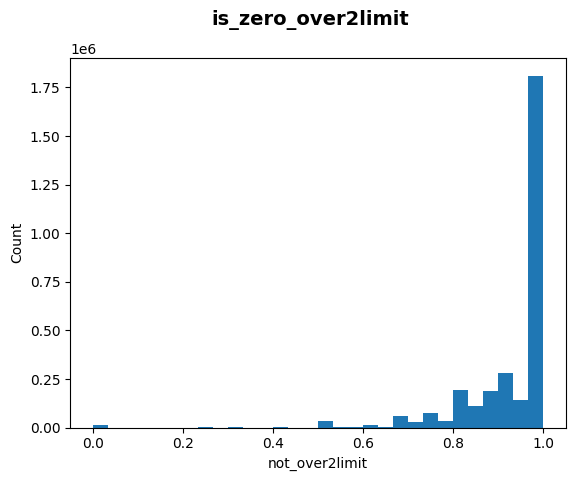

In [10]:
plt.hist(df_over2limit['not_over2limit'], density=False, bins=30) 
plt.suptitle('is_zero_over2limit', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_over2limit')

У 60% клиентов нет текущей просроченной задолженности по кредитам.

**is_zero_maxover2limit**

In [11]:
df_maxover2limit = pd.DataFrame()

df_maxover2limit['Sum_maxover2limit'] = df.groupby('id').agg({'is_zero_maxover2limit': 'sum'})
df_maxover2limit['Count_cred'] = df.groupby('id').agg({'is_zero_maxover2limit': 'count'})

In [12]:
df_maxover2limit['not_maxover2limit'] = round(df_maxover2limit['Sum_maxover2limit']/df_maxover2limit['Count_cred'], 2)

In [13]:
df_maxover2limit

,Sum_maxover2limit,Count_cred,not_maxover2limit
id,,,
0,9,10,0.90
1,11,14,0.79
2,2,3,0.67
3,14,15,0.93
4,1,1,1.00
...,...,...,...
2999995,7,11,0.64
2999996,11,13,0.85
2999997,9,10,0.90


Text(0.5, 0, 'not_maxover2limit')

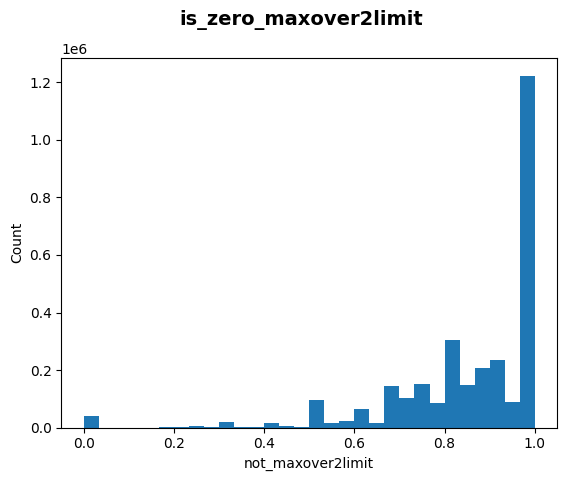

In [14]:
plt.hist(df_maxover2limit['not_maxover2limit'], density=False, bins=30) 
plt.suptitle('is_zero_maxover2limit', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_maxover2limit')

У 40% клиентов не было просроченной задолженности по кредитам.

**pclose_flag**

In [15]:
df_pclose_flag = pd.DataFrame()

df_pclose_flag['Sum_pclose_flag'] = df.groupby('id').agg({'pclose_flag': 'sum'})
df_pclose_flag['Count_cred'] = df.groupby('id').agg({'pclose_flag': 'count'})

In [16]:
df_pclose_flag['not_pclose_flag'] = round(df_pclose_flag['Sum_pclose_flag']/df_pclose_flag['Count_cred'], 2)

In [17]:
df_pclose_flag

,Sum_pclose_flag,Count_cred,not_pclose_flag
id,,,
0,1,10,0.10
1,1,14,0.07
2,2,3,0.67
3,5,15,0.33
4,1,1,1.00
...,...,...,...
2999995,2,11,0.18
2999996,5,13,0.38
2999997,1,10,0.10


Text(0.5, 0, 'not_pclose_flag')

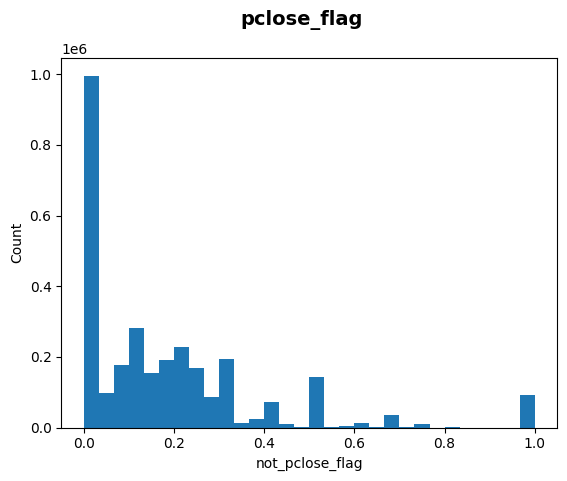

In [18]:
plt.hist(df_pclose_flag['not_pclose_flag'], density=False, bins=30) 
plt.suptitle('pclose_flag', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_pclose_flag')

У 33% клиентов по кредитам определено плановое кол-во дней с даты открытия до даты закрытия кредита.

**fclose_flag**

In [19]:
df_fclose_flag = pd.DataFrame()

df_fclose_flag['Sum_fclose_flag'] = df.groupby('id').agg({'fclose_flag': 'sum'})
df_fclose_flag['Count_cred'] = df.groupby('id').agg({'fclose_flag': 'count'})

In [20]:
df_fclose_flag['not_fclose_flag'] = round(df_fclose_flag['Sum_fclose_flag']/df_fclose_flag['Count_cred'], 2)

In [21]:
df_fclose_flag

,Sum_fclose_flag,Count_cred,not_fclose_flag
id,,,
0,2,10,0.20
1,2,14,0.14
2,2,3,0.67
3,6,15,0.40
4,1,1,1.00
...,...,...,...
2999995,5,11,0.45
2999996,4,13,0.31
2999997,1,10,0.10


Text(0.5, 0, 'not_fclose_flag')

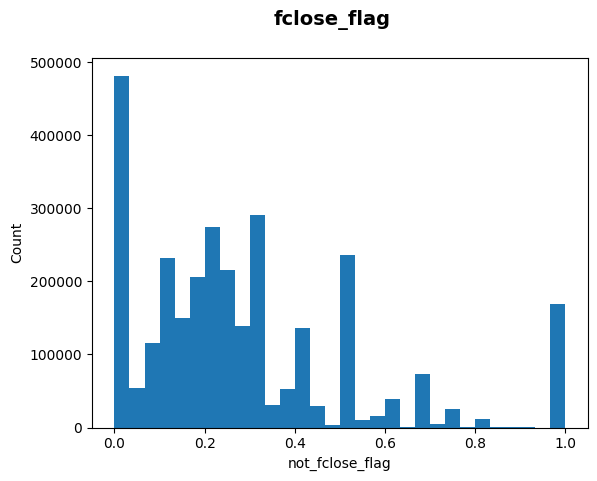

In [22]:
plt.hist(df_fclose_flag['not_fclose_flag'], density=False, bins=30) 
plt.suptitle('fclose_flag', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('not_fclose_flag')

16% клиентов имеют закрытые кредиты, то есть фактическое кол-во дней с даты открытия до даты закрытия определено. 5% клиентов не имеют закрытых кредитов. А остальная часть клиентов имеют от 1 до N незакрытых кредитов.

### 2. Обработка данных

In [ ]:
def making_dummies(df_for_dummies):
    #все фичи кроме id и rn 
    col_feat = list(df_for_dummies.columns.values)[2:] 
    
    #делаем дамми переменные
    df_only_dummies = pd.get_dummies(df_for_dummies[col_feat], columns=col_feat)
    col_dummy = df_only_dummies.columns.values
    
    #объединяем датафреймы
    df_with_all_feature = pd.concat([df_for_dummies, df_only_dummies], axis=1)  
    df_res = df_with_all_feature.drop(columns=col_feat)

    #агрегируем данные
    df_one_app = df_res.groupby("id")[col_dummy].sum().reset_index(drop=False)
    
    return df_one_app

In [24]:
files = glob('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/*.pq')

In [25]:
files

['/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_9.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_11.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_8.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_10.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_3.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_7.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_6.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_2.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_5.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_1.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_0.pq',
 '/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_4.pq']

In [26]:
%%time

df_res = pd.DataFrame()

for f in files[:]:
    print('File:', f)
    data = pd.read_parquet(f, engine = 'fastparquet')
    df_one_app = making_dummies(data)
    print('End dummies')
    df_res = pd.concat([df_res, df_one_app], axis=0) 

File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_9.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_11.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_8.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_10.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_3.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_7.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_6.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_2.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_5.pq
End dummies
File: /Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Данные/train_data_1.pq
End dummies
File: /Users/anastasts/Мой диск/Магис

In [27]:
df_res.fillna(np.uint8(0), inplace=True)

In [28]:
df_res = df_res.sort_values('id')

In [58]:
df_res

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,fclose_flag_0,fclose_flag_1,pre_loans5_11,pre_loans3060_6,pre_since_confirmed_15,pre_loans3060_4,pre_loans6090_0,pre_loans3060_3,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0
0,0,0,1,1,1,1,2,0,1,0,...,8,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,0,0,1,2,...,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0,0,0,0,0,...,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,3,1,0,2,1,3,0,0,...,9,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,2999995,1,2,0,0,2,0,1,0,0,...,6,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249996,2999996,0,1,0,1,1,5,0,0,1,...,9,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249997,2999997,0,0,1,1,3,0,0,0,0,...,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249998,2999998,0,0,0,0,1,0,0,1,0,...,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df_res.to_parquet('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Подготовленные_данные/res.parquet', 
                  index=False, engine='fastparquet')

In [30]:
# df_res = pd.read_parquet('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Подготовленные_данные/res.parquet', 
#                   index=False, engine='fastparquet')

Добавим целевую переменную в датасет

In [31]:
df_target.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Итоговая выборка

In [32]:
df_all = df_res.merge(df_target, on='id')

In [34]:
df_all

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,fclose_flag_1,pre_loans5_11,pre_loans3060_6,pre_since_confirmed_15,pre_loans3060_4,pre_loans6090_0,pre_loans3060_3,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,flag
0,0,0,1,1,1,1,2,0,1,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,1,0,0,0,0,1,2,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,1,0,0,0,0,0,0,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0,3,1,0,2,1,3,0,0,...,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0,0,0,0,0,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2999995,1,2,0,0,2,0,1,0,0,...,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999996,2999996,0,1,0,1,1,5,0,0,1,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999997,2999997,0,0,1,1,3,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999998,2999998,0,0,0,0,1,0,0,1,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [35]:
df_all.to_parquet('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Подготовленные_данные/all_data.parquet', 
                  index=False, engine='fastparquet')